# Lab | Variational Autoencoder (VAE) on Fashion-MNIST Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, datasets
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers and backend
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
###
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import keras

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


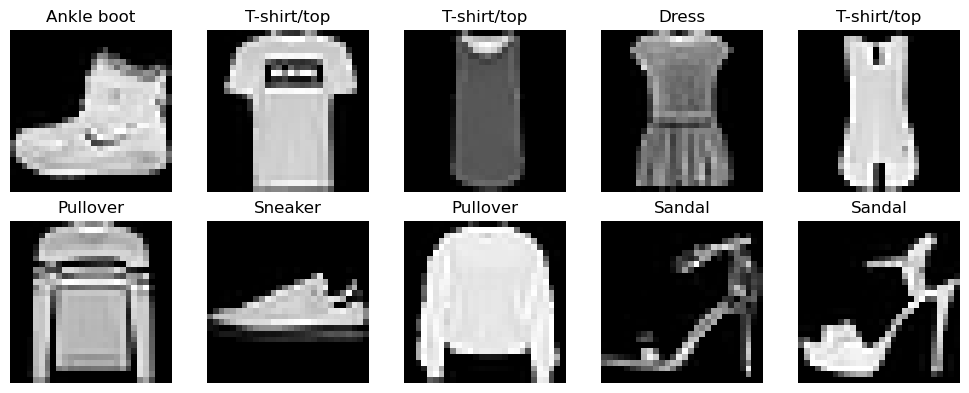

In [2]:
# Load and preprocess Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to (batch, 28, 28, 1) for Conv2D layers
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display some sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Sampling layer for the VAE
#TODO: YOUR CODE HERE
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(42)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# Build the encoder
latent_dim = 2  # 2D latent space for easy visualization
original_dim = 28 * 28
#TODO: YOUR CODE HERE
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 894,596 (3.41 MB)

 Trainable params: 894,596 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,905 (3.52 MB)

 Trainable params: 923,905 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the VAE model
#TODO: YOUR CODE HERE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # FIXED: sum over axes (1, 2, 3)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                   tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
              )
            )
            kl_loss = -0.5 * self.beta * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [12]:
# Train the VAE
#TODO: YOUR CODE HERE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))
history = vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 347s 728ms/step - kl_loss: 2.2714 - loss: 278.5143 - reconstruction_loss: 276.2290
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 375s 800ms/step - kl_loss: 2.0862 - loss: 265.6308 - reconstruction_loss: 263.5437
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 336s 717ms/step - kl_loss: 2.0297 - loss: 262.6390 - reconstruction_loss: 260.6126
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 330s 704ms/step - kl_loss: 2.0358 - loss: 261.1090 - reconstruction_loss: 259.0677
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 309s 659ms/step - kl_loss: 2.0335 - loss: 259.7401 - reconstruction_loss: 257.7071
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 313s 668ms/step - kl_loss: 2.0413 - loss: 258.6979 - reconstruction_loss: 256.6576
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 343s 731ms/step - kl_loss: 2.0502 - loss: 257.6409 - reconstruction_loss: 255.5860
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 323s 688ms/step - kl_loss: 2.0597 - loss: 257.1592 - reconstruction_loss: 255.0939
Epoch 9/30
469/4

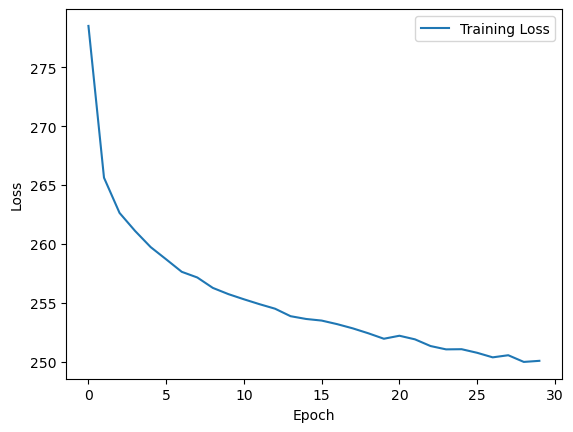

In [13]:
# Plot training history
#TODO: YOUR CODE HERE
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


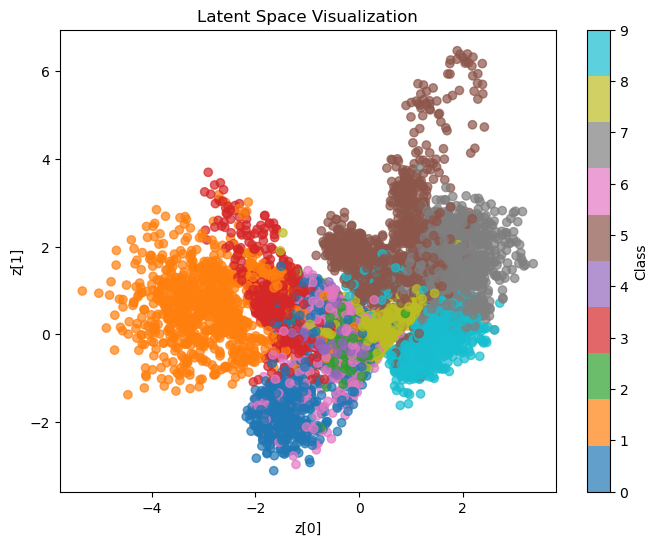

In [14]:
# Visualize the latent space
#TODO: YOUR CODE HERE
z_mean, _, _ = encoder.predict(x_test, batch_size=128)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.title('Latent Space Visualization')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


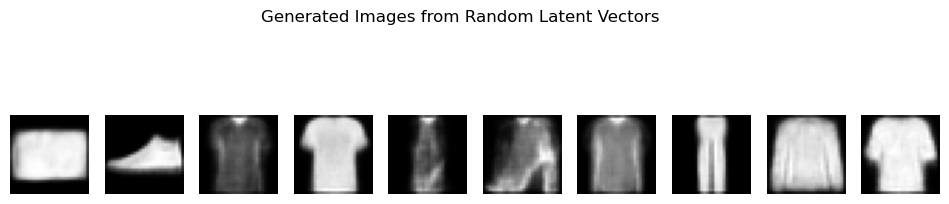

In [15]:
#####################################################
# Generate new images by sampling from latent space #
#####################################################

### YOUR CODE HERE
n_samples = 10
random_latent_vectors = np.random.normal(size=(n_samples, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

plt.figure(figsize=(12, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    # FIXED: use np.squeeze for clarity
    plt.imshow(np.squeeze(generated_images[i]), cmap='gray')
    plt.axis('off')
plt.suptitle('Generated Images from Random Latent Vectors')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


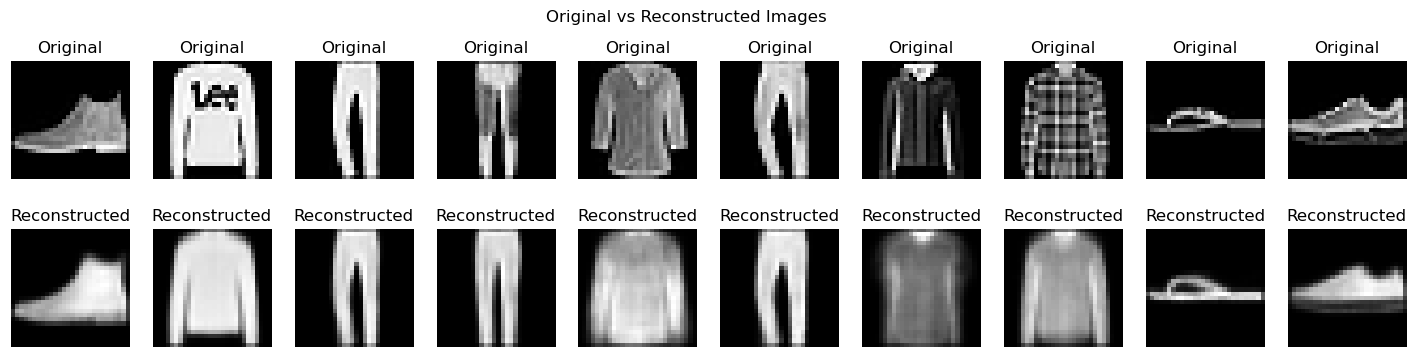

In [16]:
#############################################
# Compare original vs reconstructed images  #
#############################################


### YOUR CODE HERE

n = 10  # Number of images to display
test_imgs = x_test[:n]
_, _, z = encoder.predict(test_imgs)
reconstructions = decoder.predict(z)

plt.figure(figsize=(18, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(test_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    # Reconstructed
    plt.subplot(2, n, n + i + 1)
    plt.imshow(np.squeeze(reconstructions[i]), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.suptitle('Original vs Reconstructed Images')
plt.show()